**员工离职率预测**

数据源：https://www.kaggle.com/c/bi-attrition-prediction/data

## LightGBM

In [1]:
import pandas as pd
import numpy as np

import warnings

warnings.filterwarnings("ignore")

pd.set_option('max.columns', 100)

import missingno as msno

%pylab inline
import seaborn as sns

from datetime import datetime

import warnings
from tqdm import tqdm

import xgboost as xgb
import lightgbm as lgb
import catboost as cab

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv('train.csv')

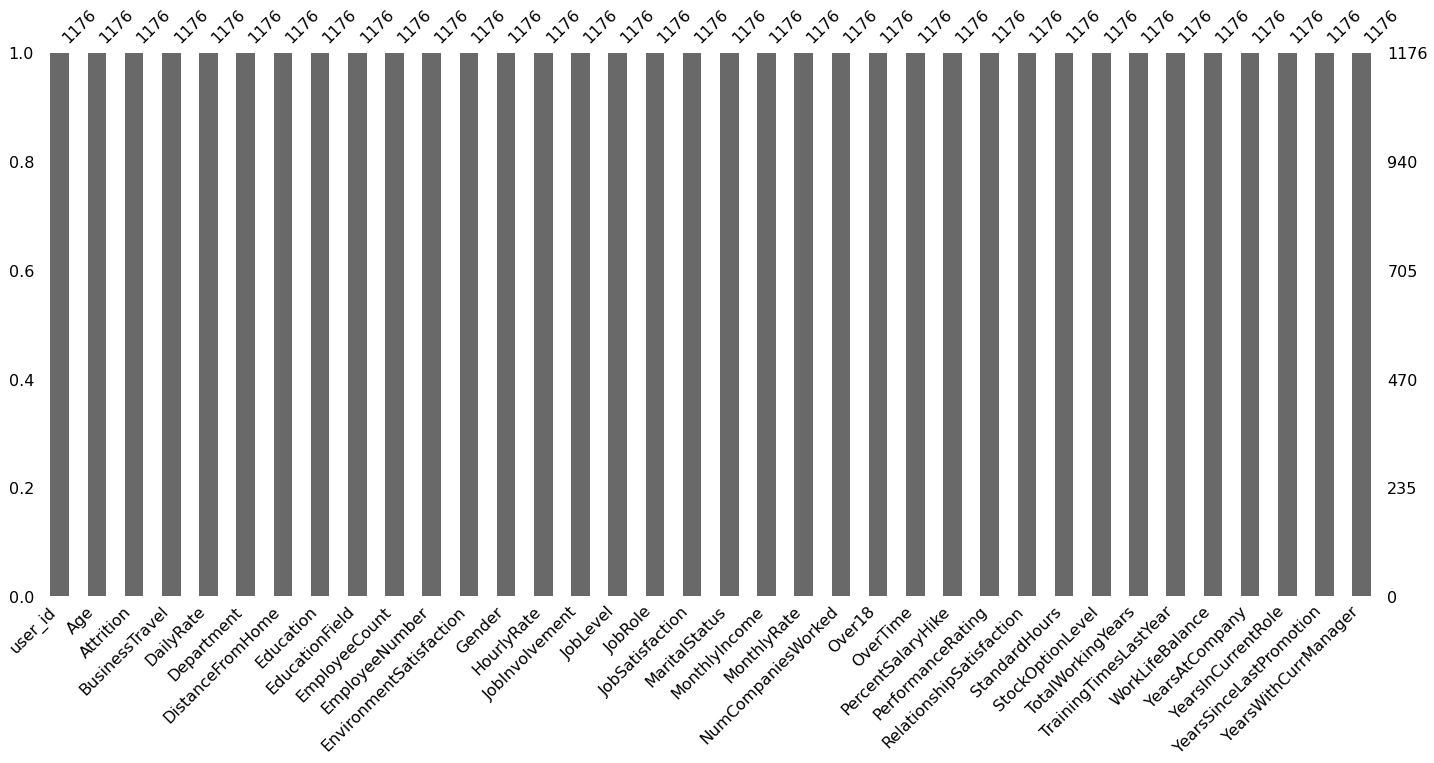

In [4]:
msno.bar(train)

In [5]:
# 查看是否有缺失值
pd.isnull(train).values.any()

False

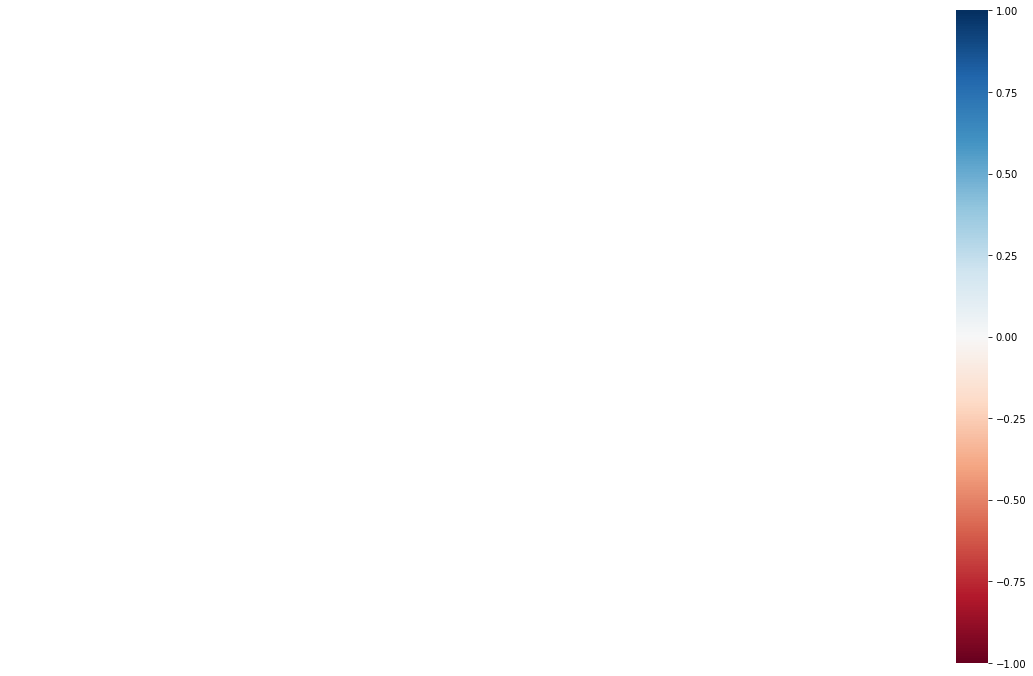

In [7]:
msno.heatmap(train.drop(['user_id','Attrition'], axis=1))

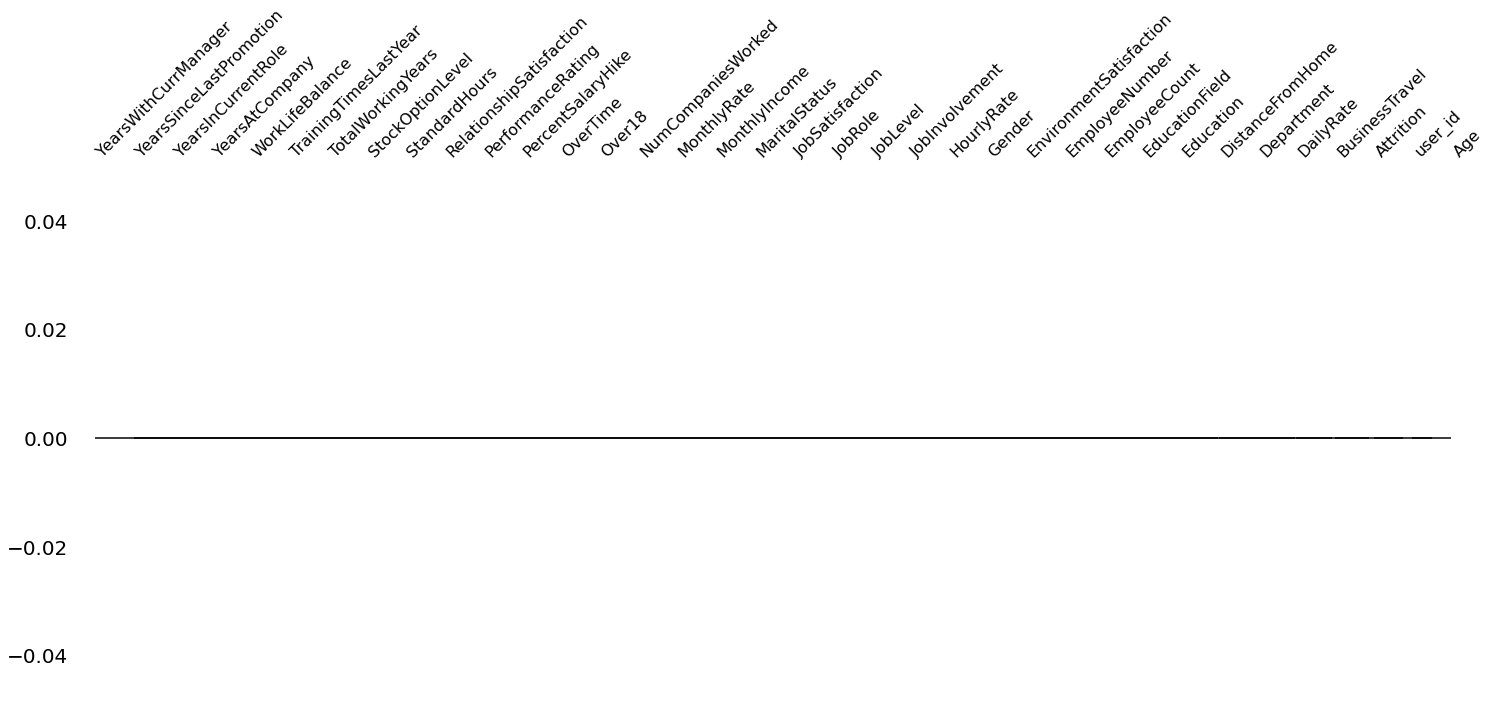

In [8]:
msno.dendrogram(train)

In [9]:
字段	说明
Age	员工年龄
Attrition	员工是否已经离职，Yes表示离职，No表示未离职
BusinessTravel	商务差旅频率，Non-Travel不出差，TravelRarely不经常出差，TravelFrequently经常出差
DailyRate	平均每日工资
Department	员工所在部门，Sales销售部，Research & Development研发部，Human Resources人力资源部
DistanceFromHome	公司跟家庭住址的距离，从1到29，1表示最近，29表示最远
Education	员工的教育程度，从1到5，5表示教育程度最高
EducationField	员工所学习的专业领域，Life Sciences表示生命科学，Medical表示医疗，Marketing表示市场营销，Technical Degree表示技术学位，Human Resources表示人力资源，Other表示其他
EmployeeNumber	员工号码
EnvironmentSatisfaction	员工对于工作环境的满意程度，从1到4，1的满意程度最低，4的满意程度最高
Gender	员工性别，Male表示男性，Female表示女性
JobInvolvement	员工工作投入度，从1到4，1为投入度最低，4为投入度最高
JobLevel	职业级别，从1到5，1为最低级别，5为最高级别
JobRole	工作角色：Sales Executive销售主管，Research Scientist科学研究员，Laboratory Technician实验室技术员，Manufacturing Director制造总监，Healthcare Representative医疗代表，Manager经理，Sales Representative销售代表，Research Director研究总监，Human Resources人力资源
JobSatisfaction	工作满意度，从1到4，1代表满意度最低，4代表最高
MaritalStatus	员工婚姻状况，Single单身，Married已婚，Divorced离婚
MonthlyIncome	员工月收入，范围在1009到19999之间
NumCompaniesWorked	员工曾经工作过的公司数
Over18	年龄是否超过18岁
OverTime	是否加班，Yes表示加班，No表示不加班
PercentSalaryHike	工资提高的百分比
PerformanceRating	绩效评估
RelationshipSatisfaction	关系满意度，从1到4，1表示满意度最低，4表示满意度最高
StandardHours	标准工时
StockOptionLevel	股票期权水平
TotalWorkingYears	总工龄
TrainingTimesLastYear	上一年的培训时长，从0到6，0表示没有培训，6表示培训时间最长
WorkLifeBalance	工作与生活平衡程度，从1到4，1表示平衡程度最低，4表示平衡程度最高
YearsAtCompany	在目前公司工作年数
YearsInCurrentRole	在目前工作职责的工作年数
YearsSinceLastPromotion	距离上次升职时长
YearsWithCurrManager	跟目前的管理者共事年数

SyntaxError: invalid syntax (<ipython-input-9-b6150a7af3f6>, line 1)

In [10]:
# 升职指数1 = 距离上次升职时长 / 在目前工作职责的工作年数
train['升职指数1'] = train['YearsSinceLastPromotion'] / train['YearsInCurrentRole']
# 升职指数2 = 距离上次升职时长 / 距离上次升职时长
train['升职指数2'] = train['YearsSinceLastPromotion'] / train['YearsSinceLastPromotion']
train['忠诚度1'] = train['YearsWithCurrManager'] / train['YearsInCurrentRole']
train['忠诚度2'] = train['YearsWithCurrManager'] / train['YearsSinceLastPromotion']

In [11]:
# 做两个特征的交叉
def cross_two(name_1, name_2):
    new_col = []
    encode = 0
    dic = {}
    val_1 = train[name_1]
    val_2 = train[name_2]
    
    for i in tqdm(range(len(val_1))):
        tmp = str(val_1[i]) + '_' + str(val_2[i])
        if tmp in dic:
            new_col.append(dic[tmp])
        else:
            dic[tmp] = encode
            new_col.append(encode)
            encode += 1
    
    return new_col

In [12]:
# 性别、出差衍生
new_col = cross_two('Gender', 'BusinessTravel')
train['Gender_BusinessTravel'] = new_col
# 专业领域、婚姻状况衍生
new_col = cross_two('EducationField', 'MaritalStatus')
train['EducationField_MaritalStatus'] = new_col
# 性别、加班衍生
new_col = cross_two('Gender', 'OverTime')
train['Gender_OverTime'] = new_col
# 加班、婚姻状况衍生
new_col = cross_two('OverTime', 'MaritalStatus')
train['OverTime_MaritalStatus'] = new_col

100%|███████████████████████████████████████████████████████████████████████████| 1176/1176 [00:00<00:00, 43675.19it/s]


In [13]:
train['OverTime_MaritalStatus'].value_counts()

1    381
2    287
5    185
0    143
3     99
4     81
Name: OverTime_MaritalStatus, dtype: int64

In [14]:
from sklearn import preprocessing
def label_encoder(df):
    standard_fea = []
    for col in df.columns:
        if df[col].dtype == 'object':
            standard_fea.append(col)
            df[col] = df[col].astype(str)
            lbl = preprocessing.LabelEncoder()
            df[col] = lbl.fit_transform(df[col])
            
    print(f'standard_fea:{standard_fea}')
    return df

In [15]:
train = label_encoder(train)

standard_fea:['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


In [16]:
train.head()

,user_id,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,升职指数1,升职指数2,忠诚度1,忠诚度2,Gender_BusinessTravel,EducationField_MaritalStatus,Gender_OverTime,OverTime_MaritalStatus
0,1374,58,0,2,605,2,21,3,1,1,1938,4,0,72,3,4,3,4,1,17875,11761,4,0,1,13,3,3,80,1,29,2,2,1,0,0,0,NaN,NaN,NaN,NaN,0,0,0,0
1,1092,45,0,2,950,1,28,3,5,1,1546,4,1,97,3,1,6,4,1,2132,4585,4,0,0,20,4,4,80,1,8,3,3,5,4,0,3,0.0,NaN,0.750000,inf,1,1,1,1
2,768,40,0,2,300,2,26,3,2,1,1066,3,1,74,3,2,7,1,1,8396,22217,1,0,0,14,3,2,80,1,8,3,2,7,7,7,5,1.0,1.0,0.714286,0.714286,1,2,1,1
3,569,36,0,0,1434,2,8,4,1,1,789,1,1,76,2,3,7,1,2,7587,14229,1,0,0,15,3,2,80,0,10,1,3,10,7,0,9,0.0,NaN,1.285714,inf,2,3,1,2
4,911,25,1,1,599,2,24,1,1,1,1273,3,1,73,1,1,8,4,2,1118,8040,1,0,1,14,3,4,80,0,1,4,3,1,0,1,0,inf,1.0,NaN,0.000000,3,3,2,3


In [20]:
features = train[[x for x in train.columns if x not in ['user_id','Attrition']]]
label = train['Attrition']
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=0)
parmas = {'num_leaves':250,
          'max_depth':7,
          'min_child_weight':0.8,
          'feature_fraction':0.8,
          'bagging_fraction':0.8,
          'min_data_in_leaf':1,
          'learning_rate':0.05,
          'boosting_type':'gbdt',
          'boosting_seed':11,
          'metric':'auc',
          'reg_alpha':1,
          'reg_lambda':1,
          'random_state':233,
          'is_unbalanced':False
         }
results = {}
gbm = lgb.LGBMClassifier(**parmas, n_estimators=800)
gbm.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        early_stopping_rounds = 100,
        verbose = 100
       )

from sklearn.model_selection import cross_val_score
accs = cross_val_score(gbm, features, y=label,scoring=None,cv=5,n_jobs=1)
print(f'交叉验证结果：{accs}')
print(f'训练集准确率：{accs.mean()}')

[LightGBM] [Warning] Unknown parameter: boosting_seed
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.733401
[200]	valid_0's auc: 0.740681
[300]	valid_0's auc: 0.746069
Early stopping, best iteration is:
[282]	valid_0's auc: 0.747525
[LightGBM] [Warning] Unknown parameter: boosting_seed
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignor

In [23]:
test = pd.read_csv('test.csv')

### 对测试集做同样的预处理

In [26]:
# 衍生升职指数
test['升职指数1']=test['YearsSinceLastPromotion']/test['YearsInCurrentRole']
test['升职指数2']=test['YearsSinceLastPromotion']/test['YearsSinceLastPromotion']
test['忠诚度1']=test['YearsWithCurrManager']/test['YearsInCurrentRole']
test['忠诚度2']=test['YearsWithCurrManager']/test['YearsSinceLastPromotion']

# 测试集作两个特征的交叉
def cross_two(name_1,name_2):
    new_col=[]
    encode=0
    dic={}
    val_1=test[name_1]
    val_2=test[name_2]
    for i in tqdm(range(len(val_1))):
        tmp=str(val_1[i])+'_'+str(val_2[i])
        if tmp in dic:
            new_col.append(dic[tmp])
        else:
            dic[tmp]=encode
            new_col.append(encode)
            encode+=1
    return new_col

# 性别出差衍生
new_col = cross_two('Gender', 'BusinessTravel')
test['Gender_BusinessTravel'] = new_col
# 专业领域、婚姻状况衍生
new_col = cross_two('EducationField', 'MaritalStatus')
test['EducationField_MaritalStatus'] = new_col
# 性别、加班衍生
new_col = cross_two('Gender', 'OverTime')
test['Gender_OverTime'] = new_col
# 加班、婚姻状况衍生
new_col = cross_two('OverTime', 'MaritalStatus')
test['OverTime_MaritalStatus'] = new_col

# 编码
test=label_encoder(test)

100%|█████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 98249.17it/s]

standard_fea:['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


In [27]:
test2 = test.copy()
del test2['user_id']
sub = gbm.predict_proba(test2)

In [31]:
test_df = test.copy()
test_df['Attrition'] = sub[:,1]
submit_csv = test_df[['user_id', 'Attrition']]
submit_csv.to_csv('submit_ban.csv', index=False)

In [32]:
submit_csv.head()

,user_id,Attrition
0,442,0.008722
1,1091,0.001982
2,981,0.125635
3,785,0.121890
4,1332,0.966837


---------feature importance---------


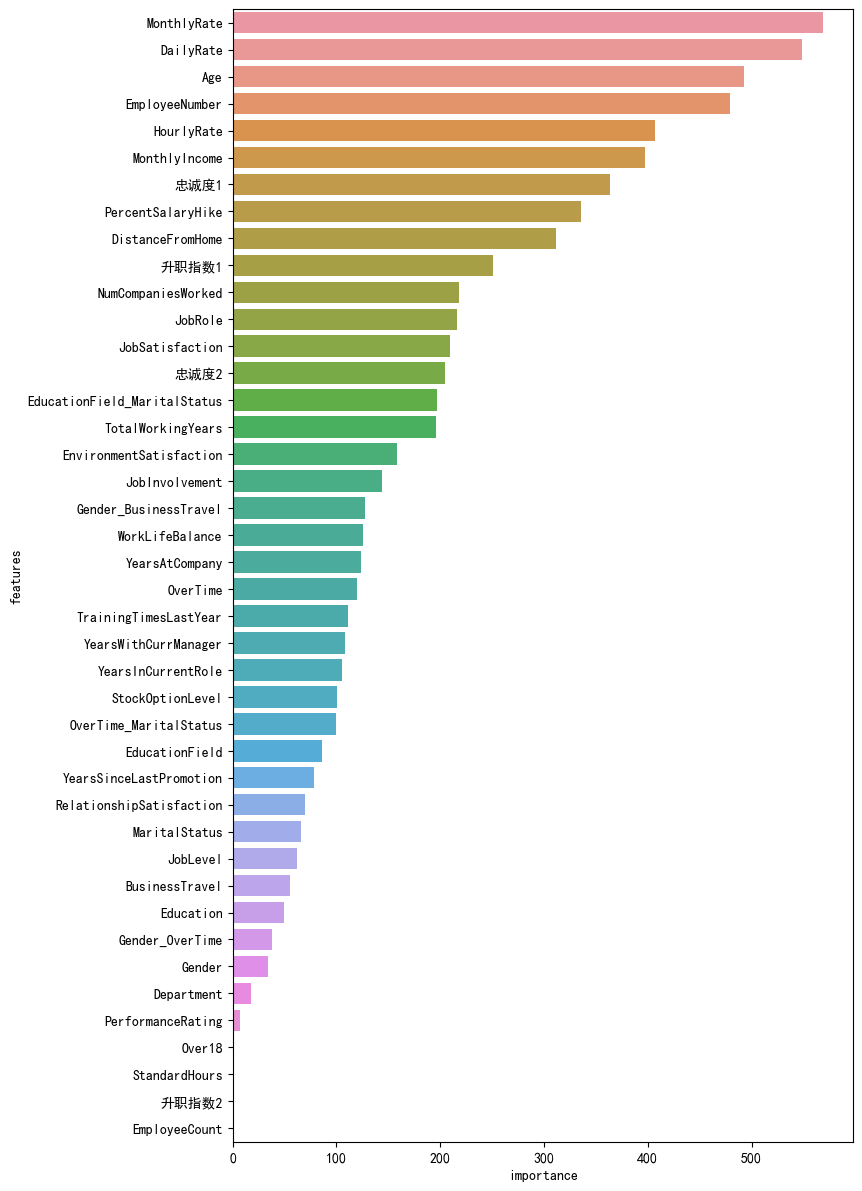

In [34]:
plt.rcParams['savefig.dpi'] = 100 # 图片像素
plt.rcParams['figure.dpi'] = 100 # 分辨率
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
def _show_feature_import(clf, train_x):
    print('---------feature importance---------')
    feature_imp = np.zeros([train_x.shape[1]])
    feature_imp += clf.feature_importances_
    feature_importance = pd.DataFrame({'features':train_x.columns, 'importance':feature_imp})
    feature_importance['importance_rate'] = feature_importance['importance'] / feature_importance['importance'].sum()
    feature_importance = feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importance['cumsum_rate'] = np.cumsum(feature_importance['importance_rate'])
    plt.figure(figsize=(8,15))
    sns.barplot(x='importance', y='features', data=feature_importance)
    plt.show()
    return feature_importance

feature_importance = _show_feature_import(gbm, X_train)

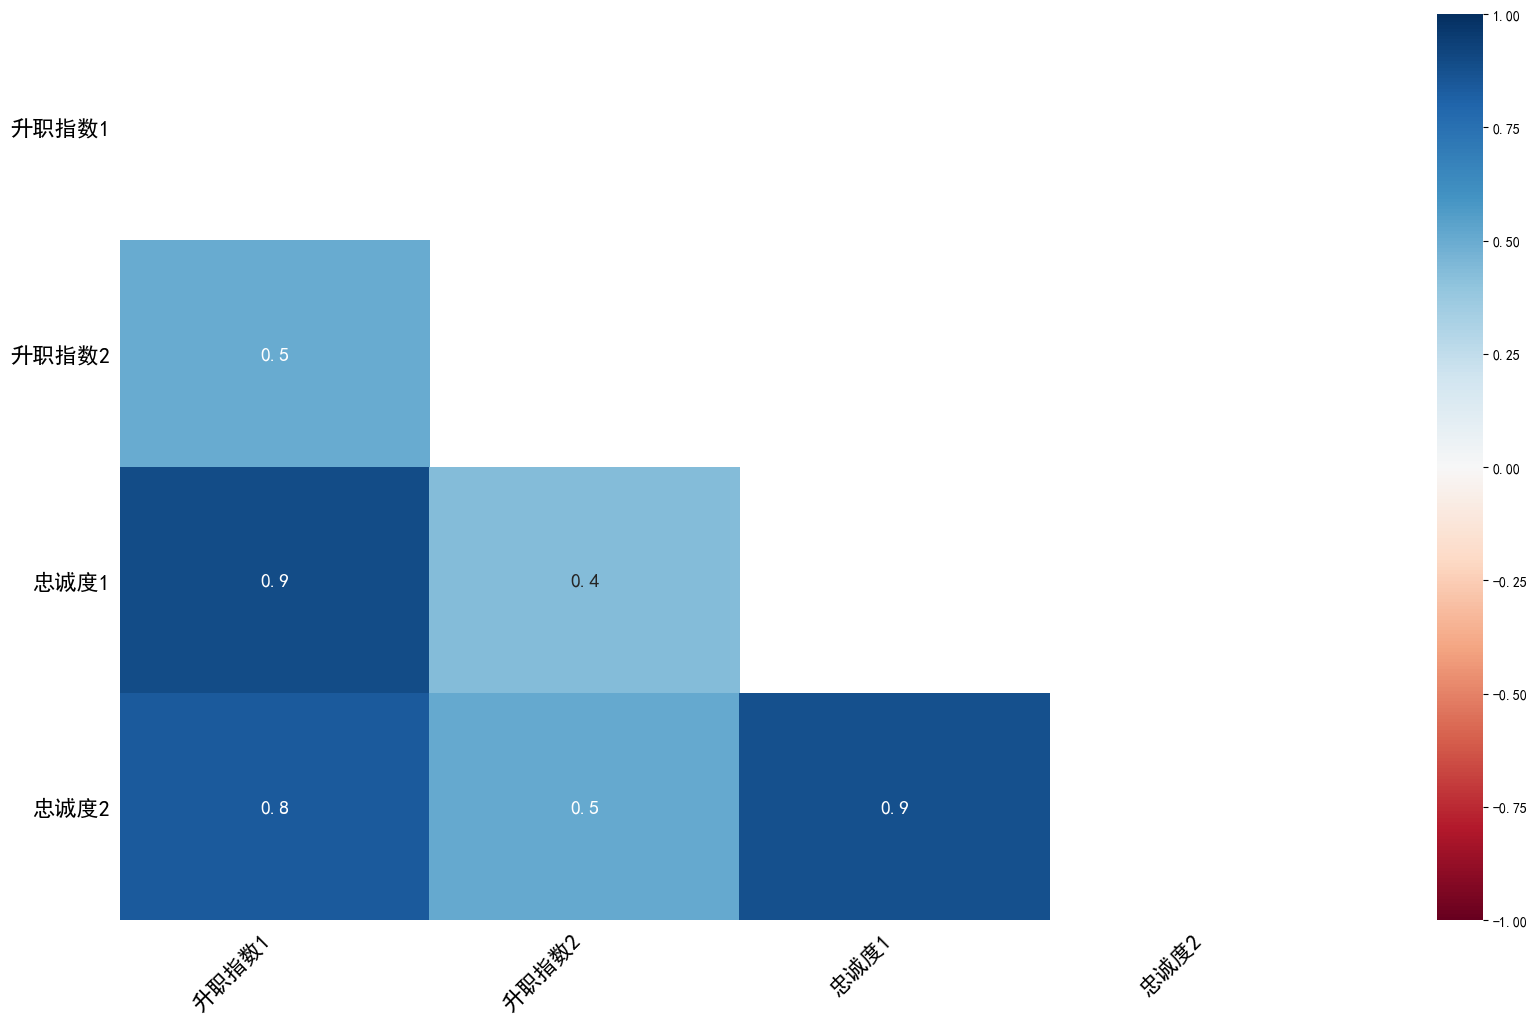

In [35]:
msno.heatmap(train.drop(['user_id','Attrition'], axis=1))

# 逻辑回归

参考：https://github.com/muxiaoxiong/bi-attrition-prediction

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

In [37]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [38]:
train_data.shape

(1176, 36)

In [39]:
# 分类数量
train_data['Attrition'].value_counts()

No     988
Yes    188
Name: Attrition, dtype: int64

In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   user_id                   1176 non-null   int64 
 1   Age                       1176 non-null   int64 
 2   Attrition                 1176 non-null   object
 3   BusinessTravel            1176 non-null   object
 4   DailyRate                 1176 non-null   int64 
 5   Department                1176 non-null   object
 6   DistanceFromHome          1176 non-null   int64 
 7   Education                 1176 non-null   int64 
 8   EducationField            1176 non-null   object
 9   EmployeeCount             1176 non-null   int64 
 10  EmployeeNumber            1176 non-null   int64 
 11  EnvironmentSatisfaction   1176 non-null   int64 
 12  Gender                    1176 non-null   object
 13  HourlyRate                1176 non-null   int64 
 14  JobInvolvement          

In [41]:
train_data['Attrition'] = train_data['Attrition'].apply(lambda x:0 if x == 'No' else 1)

In [42]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   user_id                   294 non-null    int64 
 1   Age                       294 non-null    int64 
 2   BusinessTravel            294 non-null    object
 3   DailyRate                 294 non-null    int64 
 4   Department                294 non-null    object
 5   DistanceFromHome          294 non-null    int64 
 6   Education                 294 non-null    int64 
 7   EducationField            294 non-null    object
 8   EmployeeCount             294 non-null    int64 
 9   EmployeeNumber            294 non-null    int64 
 10  EnvironmentSatisfaction   294 non-null    int64 
 11  Gender                    294 non-null    object
 12  HourlyRate                294 non-null    int64 
 13  JobInvolvement            294 non-null    int64 
 14  JobLevel                  

In [44]:
train_data.describe()

,user_id,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.00000,1176.000000,1176.000000
mean,736.124150,36.805272,0.159864,802.033163,9.159864,2.918367,1.0,1026.960034,2.750850,65.130102,2.724490,2.055272,2.732993,6458.690476,14247.159864,2.703231,15.152211,3.150510,2.714286,80.0,0.805272,11.161565,2.767007,2.764456,6.982143,4.19898,2.160714,4.098639
std,419.336964,9.065549,0.366636,405.946729,8.137224,1.009809,0.0,594.763609,1.096221,20.294326,0.715027,1.106040,1.102477,4724.845883,7133.767499,2.521301,3.652543,0.357723,1.080583,0.0,0.865611,7.747576,1.250756,0.713251,6.094338,3.63124,3.208052,3.564190
min,0.000000,18.000000,0.000000,104.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000
25%,374.750000,30.000000,0.000000,463.500000,2.000000,2.000000,1.0,498.750000,2.000000,48.000000,2.000000,1.000000,2.000000,2858.750000,7912.750000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.00000,0.000000,2.000000
50%,742.500000,36.000000,0.000000,805.500000,7.000000,3.000000,1.0,1031.000000,3.000000,65.000000,3.000000,2.000000,3.000000,4850.500000,14225.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.00000,1.000000,3.000000
75%,1101.250000,42.250000,0.000000,1162.000000,14.000000,4.000000,1.0,1555.250000,4.000000,82.250000,3.000000,3.000000,4.000000,8380.250000,20372.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.00000,2.250000,7.000000
max,1469.000000,60.000000,1.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.00000,15.000000,17.000000


In [45]:
# 全部数据
data=train_data.append(test_data)

In [46]:
# 删除无意义列，即EmployeeNumber，StandardHours，Over18
train_data.drop(columns=['EmployeeNumber','StandardHours','Over18'], inplace=True)
test_data.drop(columns=['EmployeeNumber','StandardHours','Over18'], inplace=True)
data.drop(columns=['EmployeeNumber','StandardHours','Over18'], inplace=True)

In [47]:
# 离散变量及其类别个数
cat_list = []
for i in train_data.columns:
    if train_data[i].dtype == 'O':
        cat_list.append(i)

for n,col in enumerate(cat_list):
    cat_num = train_data[col].value_counts().index.shape[0]
    print(f'{n+1}. {col}特征的类型数量是{cat_num}')

1. BusinessTravel特征的类型数量是3
2. Department特征的类型数量是3
3. EducationField特征的类型数量是6
4. Gender特征的类型数量是2
5. JobRole特征的类型数量是9
6. MaritalStatus特征的类型数量是3
7. OverTime特征的类型数量是2


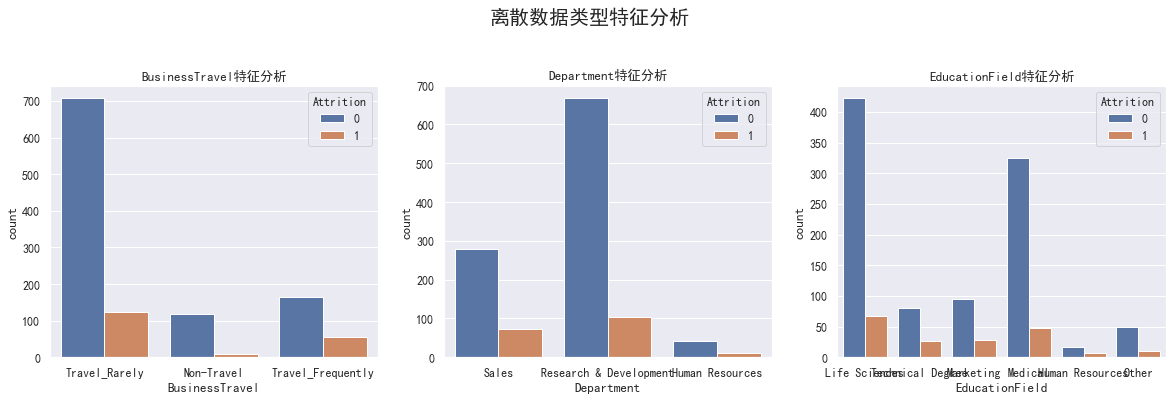

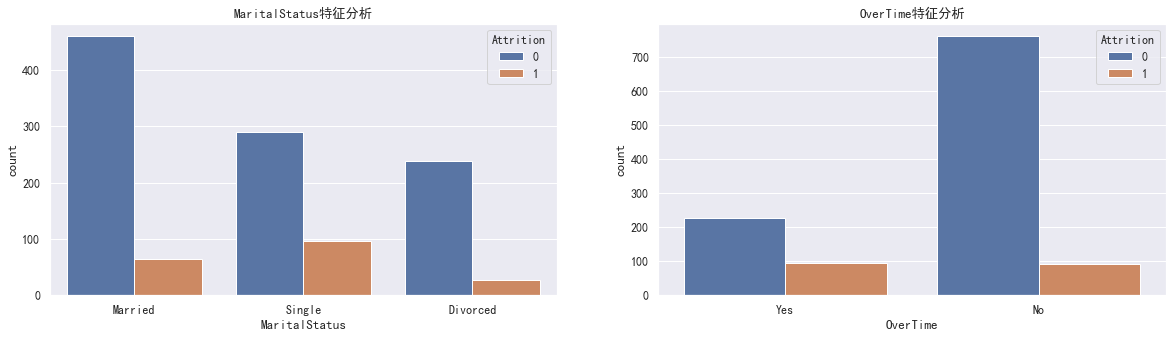

In [50]:
# 对各个离散变量分别与标签进行可视化
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 解决负号不显示问题
sns.set(font='SimHei', font_scale=1.1) # 解决seaborn中文不显示问题
f, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(20,5))
sns.countplot(x='BusinessTravel', hue='Attrition', data=train_data, ax=ax1)
sns.countplot(x='Department', hue='Attrition', data=train_data, ax=ax2)
sns.countplot(x='EducationField', hue='Attrition', data=train_data, ax=ax3)
ax1.set_title('BusinessTravel特征分析')
ax2.set_title('Department特征分析')
ax3.set_title('EducationField特征分析')
f.suptitle('离散数据类型特征分析',size=20,y=1.1)
f,[ax1,ax2] = plt.subplots(1,2,figsize=(20,5))
sns.countplot(x='MaritalStatus', hue='Attrition', data=train_data, ax=ax1)
sns.countplot(x='OverTime', hue='Attrition', data=train_data, ax=ax2)
ax1.set_title('MaritalStatus特征分析')
ax2.set_title('OverTime特征分析')

plt.show()

观察可知经常出差的离职率是最高的；研究部门的人数占比最多，但是销售部门的人员流动性更高，即离职率更高；男性且单身的离职率相对较高

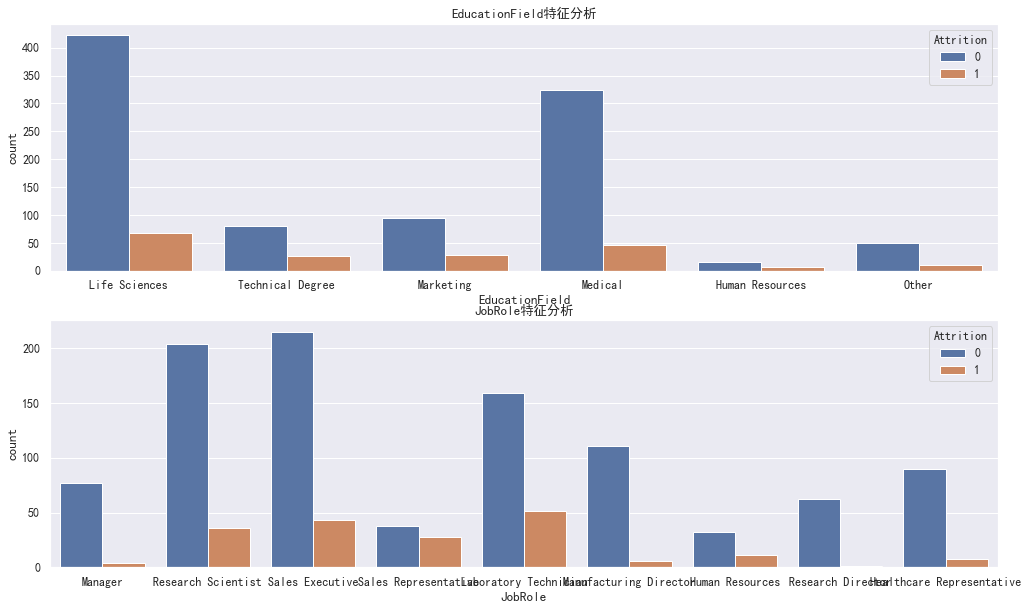

In [52]:
f,[ax1,ax2] = plt.subplots(2,1,figsize=(17,10))
sns.countplot(x='EducationField', hue='Attrition', data=train_data, ax=ax1)
sns.countplot(x='JobRole', hue='Attrition', data=train_data, ax=ax2)
ax1.set_title('EducationField特征分析')
ax2.set_title('JobRole特征分析')

plt.show()

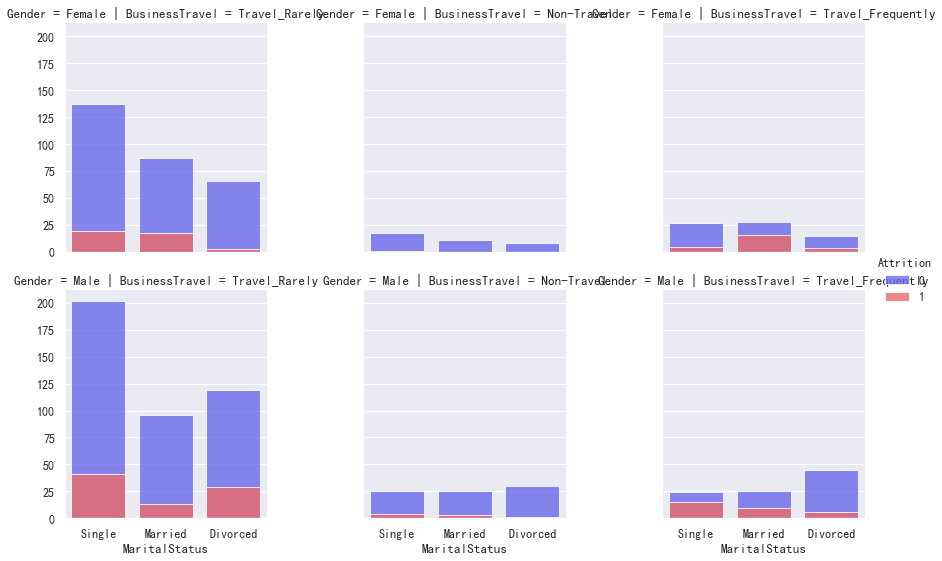

In [54]:
# 不同出差频率下，男性和女性在单身情况的数量对比
grid = sns.FacetGrid(train_data,row='Gender',col='BusinessTravel',hue='Attrition',palette='seismic',size=4)
grid.map(sns.countplot, 'MaritalStatus', alpha=0.8)
grid.add_legend()

经常出差的单身女性离职率较高

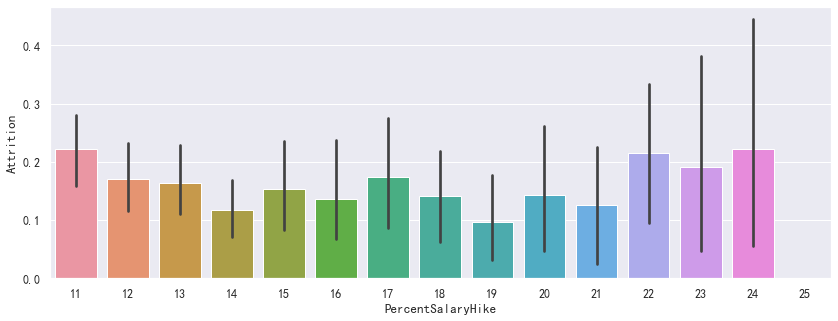

In [55]:
# 工资提高的离职情况分布
plt.figure(figsize=(14,5))
sns.barplot(x='PercentSalaryHike', y='Attrition', data=train_data)

plt.show()

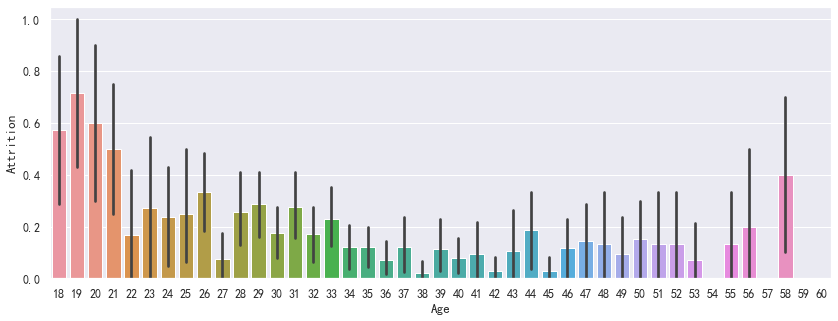

In [56]:
# 年龄的离职情况分布
plt.figure(figsize=(14,5))
sns.barplot(x='Age', y='Attrition', data=train_data)

plt.show()

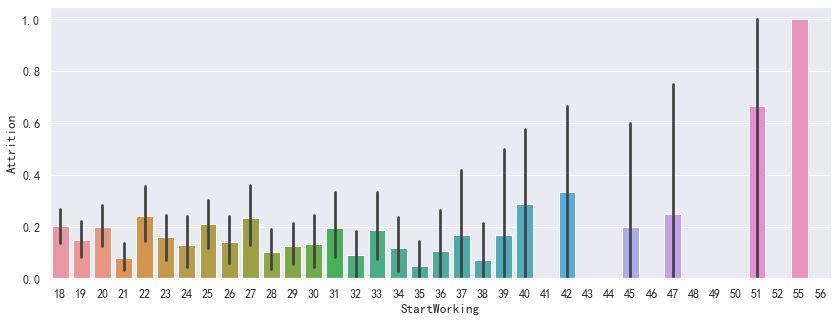

In [58]:
# 衍生出开始工作年龄
data['StartWorking'] = data['Age'] - data['TotalWorkingYears']
plt.figure(figsize=(14,5))
sns.barplot(x='StartWorking', y='Attrition', data=data.iloc[:train_data.shape[0]])

plt.show()

In [59]:
# 根据可视化图重设年龄分组，便于后续分类
def resetAge(input):
    if ((input < 24) & (input > 18)) | (input == 58):
        return 1
    elif (input == 18) | (input == 48) | (input == 54) | (input == 57) | (input < 58):
        return 0
    else:
        return 2

In [60]:
# 根据可视化图重设薪酬分组便于后续分类
def resetSalary(input):
    if (input>0) & (input<3725):
        return 0
    elif (input>=3725) & (input<111250):
        return 1
    else:
        return 2

In [61]:
# 根据可视化图重设工资提高百分比分组便于后续分类
def resetPerHike(input):
    if (input>=22) & (input<25):
        return 0
    elif ((input>=11) & (input<14)) |((input>14) & (input <22)):
        return 1
    else:
        return 2

In [62]:
# 根据可视化图重设开始工作年龄分组
def resetStart(input):
    if (input==49)|(input==51):
        return 3
    elif (input==22)|(input==27)|(input==31)|(input==40):
        return 2
    elif (input==42)|((input>43)&(input<49))|(input==50)|(input>=52):
        return 0
    else:
        return 1

In [63]:
data['Age'] = data['Age'].apply(resetAge)
data['MonthlyIncome']=data['MonthlyIncome'].apply(resetSalary)
data['PercentSalaryHike']=data['PercentSalaryHike'].apply(resetPerHike)
data['StartWorking']=data['StartWorking'].apply(resetStart)

In [66]:
# 离散变量独热编码
cata_result = pd.DataFrame()
for i in data.columns:
    if data[i].dtype=='O':
        cata = pd.DataFrame()
        cata = pd.get_dummies(data[i], prefix=i)
        cata_result = pd.concat([cata_result, cata], axis=1)

In [67]:
# 删除离散变量的特征
for i in data.columns:
    if data[i].dtype=='O':
        data = data.drop(i, axis=1)

In [68]:
data = pd.concat([data,cata_result], axis=1)

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [74]:
# 分开训练集与测试集
# 这里并没有删除user_id
num = train_data.shape[0]
train_val_y = train_data.iloc[:num]['Attrition']
train_val_x = data.iloc[:num].drop(columns=['Attrition'])
test_x = data.iloc[num:].drop('Attrition', axis=1) 

train_x, val_x, train_y, val_y = train_test_split(train_val_y, train_val_x, test_size=0.25,random_state=2021)

In [75]:
# 建立多个算法的模型
model = {}
model['rfc'] = RandomForestClassifier()
model['gbdt'] = GradientBoostingClassifier()
model['cart'] = DecisionTreeClassifier()
model['knn'] = KNeighborsClassifier()
model['svm'] = svm.SVC()
model['lr'] = LogisticRegression()

for i in model:
    model[i].fit(train_val_x, train_val_y)
    score = cross_val_score(model[i], train_val_x, train_val_y, cv=5,scoring='roc_auc')
    print('%s的auc为：%.3f'%(i,score.mean()))

rfc的auc为：0.784
gbdt的auc为：0.786
cart的auc为：0.597
knn的auc为：0.508
svm的auc为：0.577
lr的auc为：0.693


In [76]:
from sklearn.model_selection import GridSearchCV
model = ['rfc','gbdt','lr']

temp = []
rfc = RandomForestClassifier(random_state=0)
params = {'n_estimators':[50,100,150,200,250],
          'max_depth':[3,5,7],
          'min_samples_leaf':[2,4,6]
         }
temp.append([rfc,params])

gbt = GradientBoostingClassifier(random_state=0)
params = {'learning_rate':[0.01,0.05,0.1,0.15,0.2],
          'n_estimators':[100,300,500],
          'max_depth':[3,5,7]
         }
temp.append([gbt, params])

lr = LogisticRegression()
params = {'C':[0.01,0.1,0.5,1,2,3,4,5,6],
          'solver':['newton-cg', 'lbfgs', 'sag']
         }
temp.append([lr, params])

for i in range(len(model)):
    best_model = GridSearchCV(temp[i][0], param_grid=temp[i][1], refit=True, cv=5).fit(train_val_x,train_val_y)
    print(model[i], ':')
    print('best parameters:', best_model.best_params_)

rfc :
best parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 250}
gbdt :
best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
lr :
best parameters: {'C': 0.5, 'solver': 'newton-cg'}


In [77]:
model = {}
model['rcf'] = RandomForestClassifier(max_depth=7,min_samples_leaf=2,n_estimators=250)
model['gbdt'] = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=300)
model['lr'] = LogisticRegression(C=0.5,solver='newton-cg')

for i in model:
    model[i].fit(train_val_x, train_val_y)
    score = cross_val_score(model[i],train_val_x,train_val_y, cv=5,scoring='roc_auc')
    print('%s的auc为：%.3f'%(i,score.mean()))

rcf的auc为：0.798
gbdt的auc为：0.792
lr的auc为：0.831


In [79]:
# 使用集成模型中的voting
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('rfc',RandomForestClassifier(max_depth=7,min_samples_leaf=2,n_estimators=250)),
   ('gdbt',GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=300)),
     ('lr',LogisticRegression(C=0.5,solver='newton-cg'))
], voting='soft')
scores=cross_val_score(voting_clf,train_val_x,train_val_y,cv=5,scoring='roc_auc')
print('%.3f'%(scores.mean()))

0.825


In [80]:
# 因此我们最后的选择是lr
model=LogisticRegression(C=0.5,solver='newton-cg').fit(train_val_x,train_val_y)
result=model.predict_proba(test_x)
test_x['Attrition'] = result[:,1]
test_x.head()

,user_id,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,StartWorking,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,442,0,635,10,4,1,2,32,3,3,4,1,15318,1,2,3,4,0,10,3,2,10,3,9,7,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0.048700
1,1091,0,575,25,3,1,4,44,2,2,2,1,24152,1,1,3,4,0,5,2,3,5,3,0,2,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0.083633
2,981,0,662,18,4,1,4,67,3,2,3,1,23288,0,1,3,3,1,5,0,2,4,2,3,2,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0.620377
3,785,0,1492,20,4,1,1,61,3,3,4,1,26542,4,1,4,4,1,14,6,3,11,10,11,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0.092413
4,1332,0,459,24,2,1,4,73,2,1,4,0,14753,1,0,4,2,0,1,3,2,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0.851901


In [81]:
test_res = test_x[['user_id', 'Attrition']]
test_res.sorted(by='Attrition', ascending=False, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'sorted'